# Grid searching parameters for TSNE

### Aim: 
Given *n* parameters, where each parameter could be of low, middle, or high value, narrow down 
the range of each parameter such that you converge on a set of parameters that gives 
**distinct clusters** when plotting the dimensionally-reduced data on a graph

### General usage guide:

- User will set a low value and a high value for each parameter (the middle-of-the-range value will be auto-generated)
- Then run the rest of the notebook to:
  - Compute the product between all low/mid/high values between each separate parameter
  - 

Note: any time you change the parameters, you need to rebuild the pipelines list. If you execute from that cell and run all below in sequence, you will be doing things correctly

In [1]:
# Import necessary libraries
import dibs_notebook_header
import dibs
import itertools
import multiprocessing
import numpy as np
import os
import pandas as pd
import time

### Set global runtime variables below

The cell immediately below should only need to be manipulated and executed once

In [2]:
num_cpu_processors = 5  # Set the maximum number of processors you are willing to use at a given time
percent_epm_train_files_to_cluster_on = 0.35  # Set a number between 0 and 1. With larger value, train time will take longer but more data will be introduced to clustering process.

# -- Parameter tuning section--

This is where the user input goes to effect clustering outcomes


In [3]:
### Model training parameters ###
pipeline_implementation = dibs.pipeline.PipelineHowland  # Another option includes dibs.pipeline.PipelineMimic
num_gmm_clusters_aka_num_colours = 7  # Sets the number of clusters that GMM will try to label
perplexity_low  = 550
perplexity_high = 800
early_exaggeration_low  = 400
early_exaggeration_high = 800
learning_rate_low  = 350
learning_rate_high = 500
### Diagnostics parameters (graphing) ###
show_cluster_graphs_in_a_popup_window = False  # Set to False to display graphs inline
graph_dimensions = (7, 6)  # length x width.

In [4]:
# Don't touch this section
perplexity_mid = (perplexity_low + perplexity_high) / 2
early_exaggeration_mid = (early_exaggeration_low + early_exaggeration_high) / 2
learning_rate_mid = (learning_rate_low + learning_rate_high) / 2

## -- End of parameter tuning section --

---

Everything below must be run from top to bottom, in sequence, to generate the 
new outputs of parameters set above

In [5]:
# Auto-generate the product between all possible parameters
kwargs_product = [
    {'tsne_perplexity': perplexity_i,
     'tsne_early_exaggeration': early_exaggeration_j,
     'tsne_learning_rate': learning_rate_k,
     'gmm_n_components': num_gmm_clusters_aka_num_colours,
     'tsne_n_components': 2, # n-D dimensionality reduction
     
     'cross_validation_k': 2,
     'cross_validation_n_jobs': 2,
     'rf_n_jobs': 2, 
     'tsne_n_jobs': 2,
    } for learning_rate_k, early_exaggeration_j, perplexity_i in itertools.product(
        [
            learning_rate_low,
            learning_rate_mid,
            learning_rate_high,
        ],
        [
#             early_exaggeration_low,
            early_exaggeration_mid,
#             early_exaggeration_high,
            
        ],
        [
            perplexity_low,
            perplexity_mid,
            perplexity_high,
        ],
    )]
pipeline_names_by_index = [f'Pipeline_{i}' for i in range(len(kwargs_product))]
print('Number of parameter permutations:', len(kwargs_product))

Number of parameter permutations: 9


In [6]:
# Queue up which data files will be added to each Pipeline
all_files = [os.path.join(dibs.config.DEFAULT_TRAIN_DATA_DIR, file) for file in os.listdir(dibs.config.DEFAULT_TRAIN_DATA_DIR)]
train_data = half_files = all_files[:int(len(all_files) * percent_epm_train_files_to_cluster_on)]
# train_data  # Uncomment this line to see which exact data files are added to the Pipeline

In [7]:
# Create list of pipelines with all of the different combinations of parameters inserted
pipelines_ready_for_building = [pipeline_implementation(name, **kwargs).add_train_data_source(*train_data) for name, kwargs in zip(pipeline_names_by_index, kwargs_product)]
#    *** Do not be alarmed if you see DEBUG logging as an output in the cell ***
#    To turn off debug output, change DIBS/config.ini [LOGGING] for [STREAM_LOG_LEVEL] from DEBUG to WARNING

2021-03-03 15:16:02,192 - dibs.base_pipeline   - DEBUG    - Added file to train data: C:\Users\killian\projects\DIBS\epm_data_csv_train\EPM-MCE-10DLC_resnet50_Maternal_EPMDec28shuffle1_700000.csv
2021-03-03 15:16:02,302 - dibs.base_pipeline   - DEBUG    - Added file to train data: C:\Users\killian\projects\DIBS\epm_data_csv_train\EPM-MCE-11DLC_resnet50_Maternal_EPMDec28shuffle1_700000.csv
2021-03-03 15:16:02,415 - dibs.base_pipeline   - DEBUG    - Added file to train data: C:\Users\killian\projects\DIBS\epm_data_csv_train\EPM-MCE-12DLC_resnet50_Maternal_EPMDec28shuffle1_700000.csv
2021-03-03 15:16:02,530 - dibs.base_pipeline   - DEBUG    - Added file to train data: C:\Users\killian\projects\DIBS\epm_data_csv_train\EPM-MCE-13DLC_resnet50_Maternal_EPMDec28shuffle1_700000.csv
2021-03-03 15:16:02,650 - dibs.base_pipeline   - DEBUG    - Added file to train data: C:\Users\killian\projects\DIBS\epm_data_csv_train\EPM-MCE-14DLC_resnet50_Maternal_EPMDec28shuffle1_700000.csv
2021-03-03 15:16:02,

2021-03-03 15:16:06,952 - dibs.base_pipeline   - DEBUG    - Added file to train data: C:\Users\killian\projects\DIBS\epm_data_csv_train\EPM-MCE-10DLC_resnet50_Maternal_EPMDec28shuffle1_700000.csv
2021-03-03 15:16:07,062 - dibs.base_pipeline   - DEBUG    - Added file to train data: C:\Users\killian\projects\DIBS\epm_data_csv_train\EPM-MCE-11DLC_resnet50_Maternal_EPMDec28shuffle1_700000.csv
2021-03-03 15:16:07,174 - dibs.base_pipeline   - DEBUG    - Added file to train data: C:\Users\killian\projects\DIBS\epm_data_csv_train\EPM-MCE-12DLC_resnet50_Maternal_EPMDec28shuffle1_700000.csv
2021-03-03 15:16:07,285 - dibs.base_pipeline   - DEBUG    - Added file to train data: C:\Users\killian\projects\DIBS\epm_data_csv_train\EPM-MCE-13DLC_resnet50_Maternal_EPMDec28shuffle1_700000.csv
2021-03-03 15:16:07,403 - dibs.base_pipeline   - DEBUG    - Added file to train data: C:\Users\killian\projects\DIBS\epm_data_csv_train\EPM-MCE-14DLC_resnet50_Maternal_EPMDec28shuffle1_700000.csv
2021-03-03 15:16:07,

### Next step: leveraging multiprocessing to get as much work done in as short a time as possible

In [8]:
# The heavy lifting/processing is done here
results_current_time = time.strftime("%Y-%m-%d_%HH%MM")
print(f'Start time: {results_current_time}')
start_time = time.perf_counter()
with multiprocessing.Pool(num_cpu_processors) as pool:
    pipelines_queued = [pool.apply_async(pipe_i.build) for pipe_i in pipelines_ready_for_building]
    pipelines_results = [res.get() for res in pipelines_queued]
end_time = time.perf_counter()
print(f'Total compute time: {round((end_time-start_time)/60, 2)} minutes.')

Start time: 2021-03-03_15H16M
Total compute time: 15.03 minutes.


In [9]:
# # Delete this cell later. its a debug cell.
# # The heavy lifting/processing is done here
# results_current_time = time.strftime("%Y-%m-%d_%HH%MM")
# print(f'Start time: {results_current_time}')
# start_time = time.perf_counter()
# print(len(pipelines_ready_for_building))
# for i, p_i in enumerate(pipelines_ready_for_building):
#     print(f'START {i}: Pipeline={p_i.name} / Frac={p_i._tsne_perplexity}')
#     try:
#         pipelines_ready_for_building[i] = p_i.build()
#     except Exception as e:
#         info = f'Perp={p_i._tsne_perplexity}/EE={p_i.tsne_early_exaggeration}/LR={p_i.tsne_learning_rate}/GMM-N={p_i.gmm_n_components}'
#         print(info)
#         raise e
#     print('--------------------------')
# end_time = time.perf_counter()
# print(f'Total compute time: {round((end_time-start_time)/60, 2)} minutes.')

Perp ratio: 0.05902 / Perp: 550.0 / EE: 600.0 / LearnRate: 350.0 


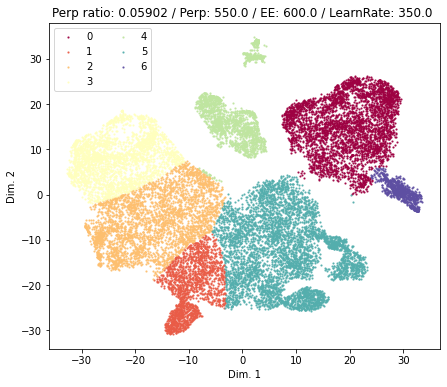

2021-03-03 15:31:10,442 - dibs.visuals         - DEBUG    - Saving graph to following path: C:\Users\killian\projects\DIBS\output\graphs\2021-03-03_15H16M__Pipeline_0___2021-03-03_15H16M.jpg


-----------------------------------
Perp ratio: 0.07243 / Perp: 675.0 / EE: 600.0 / LearnRate: 350.0 


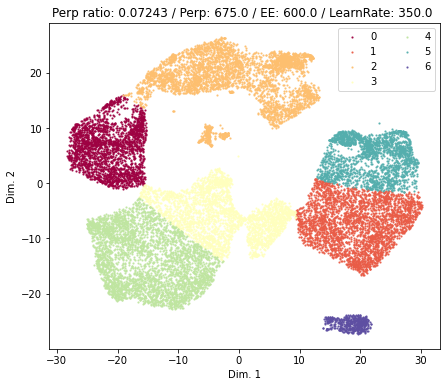

2021-03-03 15:31:10,966 - dibs.visuals         - DEBUG    - Saving graph to following path: C:\Users\killian\projects\DIBS\output\graphs\2021-03-03_15H16M__Pipeline_1___2021-03-03_15H16M.jpg


-----------------------------------
Perp ratio: 0.08585 / Perp: 800.0 / EE: 600.0 / LearnRate: 350.0 


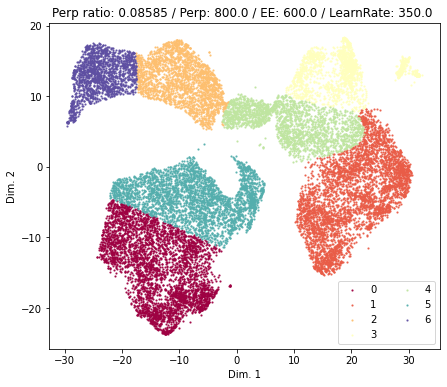

2021-03-03 15:31:11,587 - dibs.visuals         - DEBUG    - Saving graph to following path: C:\Users\killian\projects\DIBS\output\graphs\2021-03-03_15H16M__Pipeline_2___2021-03-03_15H16M.jpg


-----------------------------------
Perp ratio: 0.05902 / Perp: 550.0 / EE: 600.0 / LearnRate: 425.0 


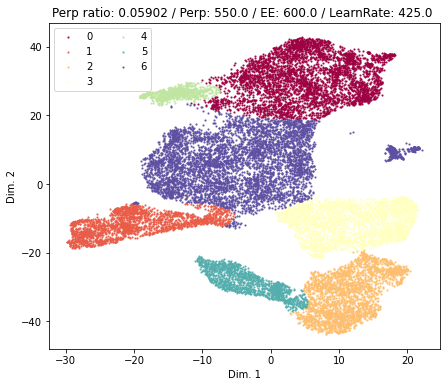

2021-03-03 15:31:12,161 - dibs.visuals         - DEBUG    - Saving graph to following path: C:\Users\killian\projects\DIBS\output\graphs\2021-03-03_15H16M__Pipeline_3___2021-03-03_15H16M.jpg


-----------------------------------
Perp ratio: 0.07243 / Perp: 675.0 / EE: 600.0 / LearnRate: 425.0 


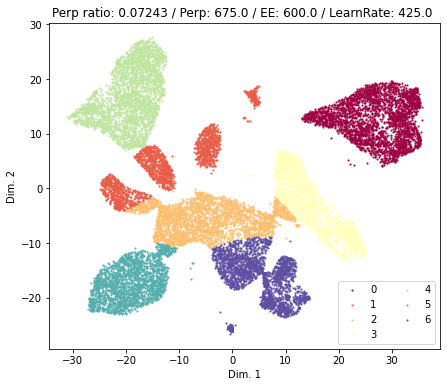

2021-03-03 15:31:12,789 - dibs.visuals         - DEBUG    - Saving graph to following path: C:\Users\killian\projects\DIBS\output\graphs\2021-03-03_15H16M__Pipeline_4___2021-03-03_15H16M.jpg


-----------------------------------
Perp ratio: 0.08585 / Perp: 800.0 / EE: 600.0 / LearnRate: 425.0 


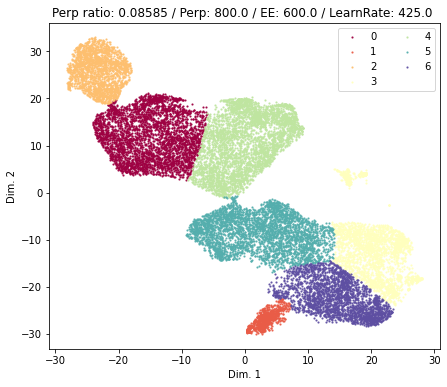

2021-03-03 15:31:13,322 - dibs.visuals         - DEBUG    - Saving graph to following path: C:\Users\killian\projects\DIBS\output\graphs\2021-03-03_15H16M__Pipeline_5___2021-03-03_15H16M.jpg


-----------------------------------
Perp ratio: 0.05902 / Perp: 550.0 / EE: 600.0 / LearnRate: 500.0 


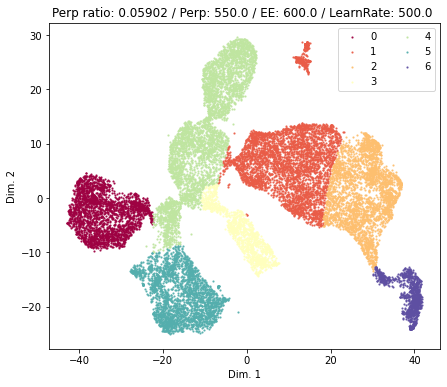

2021-03-03 15:31:13,810 - dibs.visuals         - DEBUG    - Saving graph to following path: C:\Users\killian\projects\DIBS\output\graphs\2021-03-03_15H16M__Pipeline_6___2021-03-03_15H16M.jpg


-----------------------------------
Perp ratio: 0.07243 / Perp: 675.0 / EE: 600.0 / LearnRate: 500.0 


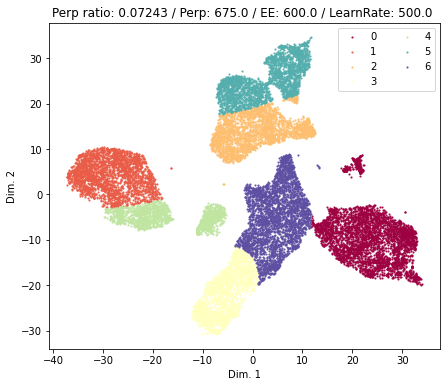

2021-03-03 15:31:14,361 - dibs.visuals         - DEBUG    - Saving graph to following path: C:\Users\killian\projects\DIBS\output\graphs\2021-03-03_15H16M__Pipeline_7___2021-03-03_15H16M.jpg


-----------------------------------
Perp ratio: 0.08585 / Perp: 800.0 / EE: 600.0 / LearnRate: 500.0 


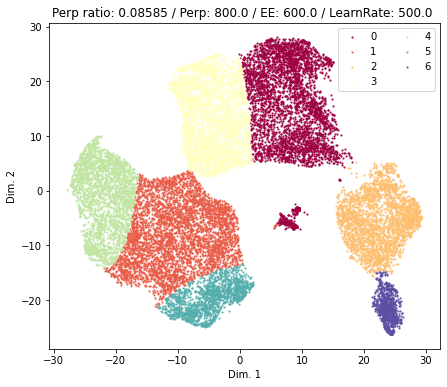

2021-03-03 15:31:14,860 - dibs.visuals         - DEBUG    - Saving graph to following path: C:\Users\killian\projects\DIBS\output\graphs\2021-03-03_15H16M__Pipeline_8___2021-03-03_15H16M.jpg


-----------------------------------


In [10]:
# Note: evaluating "goodness" of a set of parameters is based on the distinctness of clusters. More distinct = better parameters set.
if show_cluster_graphs_in_a_popup_window:
    %matplotlib qt
else:
    %matplotlib inline
for i, pipeline_i in enumerate(pipelines_results):
    perplexity_ratio_i, perplexity_i, learning_rate_i, early_exaggeration_i = pipeline_i.tsne_perplexity_relative_to_num_data_points, pipeline_i.tsne_perplexity, pipeline_i.tsne_learning_rate, pipeline_i.tsne_early_exaggeration

    title = f"Perp ratio: {round(perplexity_ratio_i, 5)} / Perp: {perplexity_i} / EE: {early_exaggeration_i} / LearnRate: {learning_rate_i} "
    print(title)
    pipeline_i.plot_clusters_by_assignments(title=title, fig_file_prefix=f'{results_current_time}__{pipeline_i.name}__', show_now=True, save_to_file=True, figsize=graph_dimensions, s=0.4 if show_cluster_graphs_in_a_popup_window else 1.5)
    print('-----------------------------------')

In [11]:
raise Exception('All done!')

Exception: All done!

### Optional, additional steps below
If you are satisfied with the distinctness of the clustering (the sign of having a "good" set of parameters), but are unhappy with the number of colours used per cluster, run the below cells with your desired number of clusters

In [ ]:
new_num_gmm_clusters_aka_num_colours = 6

In [ ]:
results_current_time_n = time.strftime("%Y-%m-%d_%HH%MM")
print(results_current_time_n)
start_time = time.perf_counter()
# pipelines_queued_new_gmm_n_clusters = [pipeline.set_params(gmm_n_clusters=new_num_gmm_clusters_aka_num_colours) for pipeline in pipelines_queued]
with multiprocessing.Pool(num_cpu_processors) as pool:
    pipelines_queued_new_gmm_n = [pool.apply_async(pipe_i.recolor_gmm_and_retrain_classifier, args=(new_num_gmm_clusters_aka_num_colours, )) for pipe_i in pipelines_results]
    pipelines_results_new_gmm_n = [res.get() for res in pipelines_queued]
end_time = time.perf_counter()
print(f'Total compute time: {round((end_time-start_time)/60, 2)} minutes.')

In [ ]:
# Note: evaluating "goodness" of a set of parameters is based on the distinctness of clusters. More distinct = better parameters set.
if show_cluster_graphs_in_a_popup_window:
    %matplotlib qt
else:
    %matplotlib inline
for i, pipeline_i in enumerate(pipelines_results_new_gmm_n):
    perplexity_i, learning_rate_i, early_exaggeration_i = pipeline_i.tsne_perplexity, pipeline_i.tsne_learning_rate, pipeline_i.tsne_early_exaggeration
    print(f"Pipeline: {pipeline_i.name} / perplexity: {perplexity_i} / learning rate: {learning_rate_i} / early_exaggeration: {early_exaggeration_i} ")
    pipeline_i.plot_clusters_by_assignments(fig_file_prefix=f'{results_current_time_n}__{pipeline_i.name}__', show_now=True, save_to_file=True, figsize=graph_dimensions, s=0.4 if show_cluster_graphs_in_a_popup_window else 1.5)
    print('-----------------------------------')

In [ ]:
pipelines_results_new_gmm_n[0].gmm_n_components